In [1]:
from scipy.io import loadmat

data = loadmat('ADHD_part1/v1p.mat')


In [2]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Apr 12 15:32:36 2020',
 '__version__': '1.0',
 '__globals__': [],
 'v1p': array([[  85, -407,  200, ...,  -90,  473,  121],
        [-266,  -55,  -20, ..., -195,  543,   15],
        [ -90,  -19,  126, ...,  -19,  613,  261],
        ...,
        [  85,  -90,   16, ..., -512,   85,   15],
        [-160,   85, -131, ..., -477,  332,  191],
        [ 226,   85,  126, ..., -336,  297,  156]], dtype=int16)}

In [3]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'v1p'])

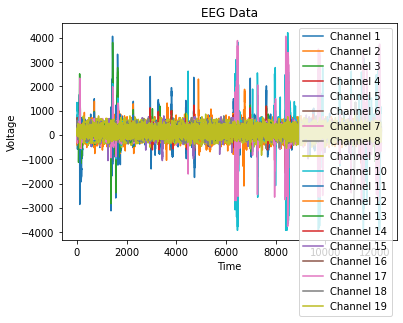

In [3]:
import numpy as np
import plotly.graph_objects as go

# Assuming 'v1p' contains your EEG data
eeg_data = data['v1p']

# Set up the initial plot
fig = go.Figure()

# Create an empty scatter plot for each channel
for channel in range(eeg_data.shape[1]):
    fig.add_trace(go.Scatter(x=[], y=[], mode='lines', name=f'Channel {channel+1}'))

# Set layout and axis labels
fig.update_layout(
    xaxis_title='Time',
    yaxis_title='Voltage',
    title='EEG Data'
)

# Start the animation frame index
frame_index = 0

# Update the plot with new data in a loop
while frame_index < eeg_data.shape[0]:
    # Extract the current frame data
    frame_data = eeg_data[frame_index, :]

    # Update the plot data for each channel
    for channel in range(eeg_data.shape[1]):
        fig.data[channel].x = np.arange(frame_index)
        fig.data[channel].y = frame_data[:frame_index]

    # Update the plot
    fig.update_layout(transition_duration=50)  # Adjust the transition duration for desired speed
    fig.show()

    frame_index += 1


In [ ]:
import torch
import torch.nn as nn
import snntorch as snn

# Define the LIF neuron model
class LIFNeuron(snn.Module):
    def __init__(self, dt):
        super(LIFNeuron, self).__init__()
        self.dt = dt
        self.tau_m = 20.0  # Membrane time constant
        self.v_reset = 0.0  # Reset potential
        self.v_threshold = 1.0  # Spike threshold
        self.refractory_period = 5.0  # Refractory period
        
        # Neuron state variables
        self.v = self.register_buffer("v", torch.zeros(1))
        self.refractory = self.register_buffer("refractory", torch.zeros(1))
        
    def forward(self, I):
        if not self.refractory:
            self.v += (-self.v + I * self.tau_m) * self.dt / self.tau_m
            
            if self.v >= self.v_threshold:
                self.v = self.v_reset
                self.refractory = self.refractory_period
                return torch.tensor(1.0)
        else:
            self.refractory -= self.dt
        
        return torch.tensor(0.0)

# Define the SNN model with LIF neurons
class LIFModel(nn.Module):
    def __init__(self, dt):
        super(LIFModel, self).__init__()
        
        self.lif1 = LIFNeuron(dt=dt)
        self.lif2 = LIFNeuron(dt=dt)

    def forward(self, x):
        spike1 = self.lif1(x)
        spike2 = self.lif2(spike1)
        return spike2

# Create an instance of the LIF model
dt = 1.0  # Time step (ms)
lif_model = LIFModel(dt=dt)

# Define input data
input_data = torch.tensor([0.2])

# Simulate the LIF model
output_spike = lif_model(input_data)

print("Output spike:", output_spike)